In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from astropy.io import fits

In [3]:
%matplotlib notebook

In [4]:
filename = 'SN2019yvq_highres_NaD_B.fits'
dat = fits.getdata(filename)
hdr = fits.getheader(filename)
wv = hdr['CRVAL1'] + hdr['CDELT1']*np.arange(hdr['NAXIS1'])

<IPython.core.display.Javascript object>


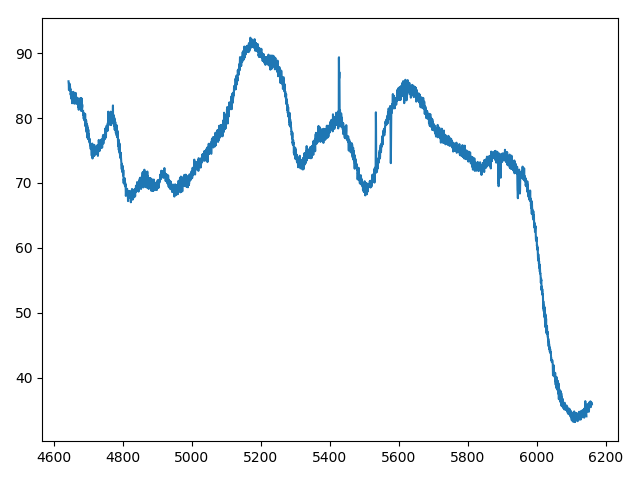

In [5]:
plt.plot(wv, dat[0]/dat[1])
# plt.plot(wv, dat[1]*90)
# plt.plot(wv, dat[3])

plt.tight_layout()

In [49]:
spec_df = pd.DataFrame(wv, columns=['wavelength'])
flux = dat[0]
flux_unc = dat[1]
for fnum, f in enumerate(flux):
    if not np.isfinite(f):
        flux[fnum] = flux[fnum-1]
        flux_unc[fnum] = flux_unc[fnum-1]

spec_df['flux'] = flux
spec_df['flux_unc'] = flux_unc
spec_df.to_csv('SN2019yvq_MMT.csv', sep=' ',index=False)

In [40]:
hdr

SIMPLE  =                    T /  Written by IDL:  Tue Jan 21 12:34:05 2020     
BITPIX  =                  -32 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 4100 /                                                
NAXIS2  =                    4 /                                                
EXTEND  =                    T / Extensions may be present                      
BSCALE  =                    1 /           /                                    
BZERO   =                    0 /           /                                    
OBSERVAT= 'mmto'                           /                                    
TELESCOP= 'mmt_f5_adc'                     /                                    
ORIGIN  = 'MMT Binospec Camera'            /                                    
INSTRUME= 'Binospec'                       /                                    
CCDSUM  = '1 1'             

### Make a figure showing the Na D feature

In [6]:
flux_plot = np.repeat(dat[0], 2)
wv_plot = wv.copy()
wv_plot[:-1] += np.diff(wv)/2
wv_plot = np.append(wv[0]-(wv[1]-wv[0])/2, np.append(np.repeat(wv_plot[0:-1], 2), wv[-1]+(wv[-1]-wv[-2])/2))

<IPython.core.display.Javascript object>


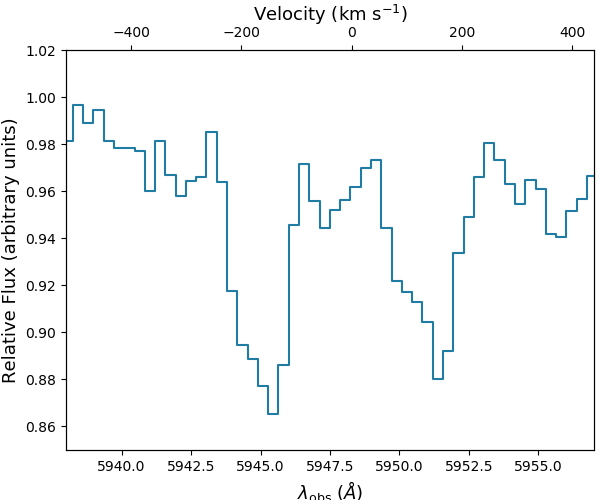

In [39]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

NaD_blue = 5889.95
NaD_red = 5895.92
z = 0.00888

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(wv_plot, flux_plot/775, 
        color = aam_colors['blue'])




ax.set_xlim(5938,5957)
ax.set_ylim(0.85,1.02)
ax.set_ylabel('Relative Flux (arbitrary units)',fontsize=13)
ax.set_xlabel(r'$\lambda_\mathrm{obs} \; (\AA)$', fontsize=13)

red_line = ax.twiny()
red_line.set_xlabel(r'Velocity (km s$^{-1}$)', fontsize=13)
red_line.set_xlim((np.array(ax.get_xlim())/(1+z)-NaD_red)/NaD_red*2.9979e5)

fig.subplots_adjust(left=0.11,right=0.99,top=0.90,bottom=0.1)
fig.savefig('../paper/figures/NaD.pdf')

In [18]:
(np.array(ax.get_xlim())/(1+z)-NaD_red)/NaD_red*2.9979e5

array([-417.09447653,  590.89510436])

In [9]:
(wv/(1+z)-NaD_red)/NaD_red*2.9979e5

array([-65763.54672321, -65744.89891572, -65726.25110824, ...,
        10636.52054987,  10655.16835735,  10673.81616484])

Some notes on these absorption lines:

For the MW component - Gaussian EW = -0.20 and Moment EW = -0.2129

For the NGC 4441 component - Gaussian EW = -0.422